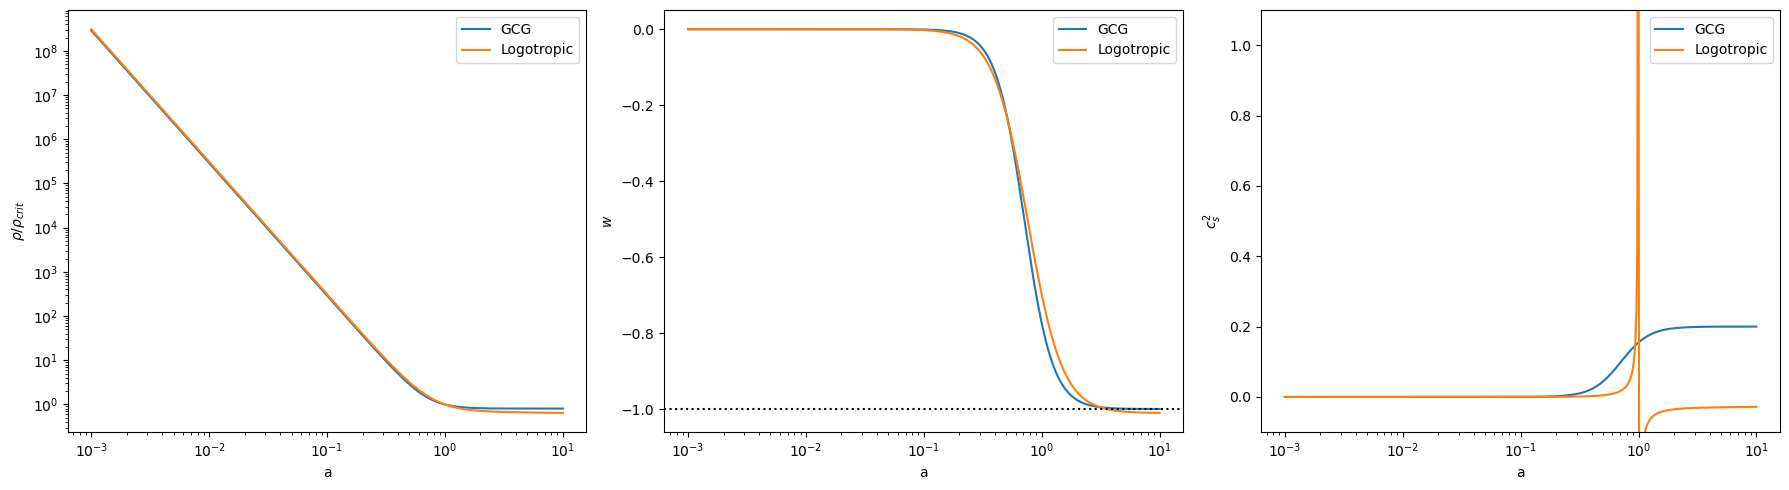

In [1]:
import sys
import os

# Adds the parent directory to the python path
sys.path.append(os.path.abspath('../'))

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from src.physics.ude_models import GCGModel, LogotropicModel, MurnaghanModel
from src.physics.cosmo_solver import CosmoSolver


# 1. Setup scale factor array
a = np.logspace(-3, 1, 500)
N = np.log(a)

# 2. Initialize Models
gcg = GCGModel(alpha=0.2)
logo = LogotropicModel(B=0.01)

# 3. Generate Data
models = {'GCG': gcg, 'Logotropic': logo}
results = {name: {'rho': [], 'w': [], 'cs2': []} for name in models}

for name, model in models.items():
    results[name]['rho'] = [model.rho_ude(ai) for ai in a]
    results[name]['w'] = [model.w_ude(ai) for ai in a]
    results[name]['cs2'] = [model.cs2(ai) for ai in a]

# 4. Plotting Comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for name in models:
    ax[0].plot(a, results[name]['rho'], label=name)
    ax[1].plot(a, results[name]['w'], label=name)
    ax[2].plot(a, results[name]['cs2'], label=name)

# Formatting
ax[0].set_ylabel(r'$\rho/\rho_{crit}$'); ax[0].set_yscale('log')
ax[1].set_ylabel(r'$w$'); ax[1].axhline(-1, color='k', ls=':')
ax[2].set_ylabel(r'$c_s^2$'); ax[2].set_ylim(-0.1, 1.1)

for i in range(3):
    ax[i].set_xlabel('a')
    ax[i].set_xscale('log')
    ax[i].legend()

plt.tight_layout()
plt.show()



<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_16370/186155679.py:23: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_title('Perturbation Growth ($\delta_m$)')


(0.01, 1.0)

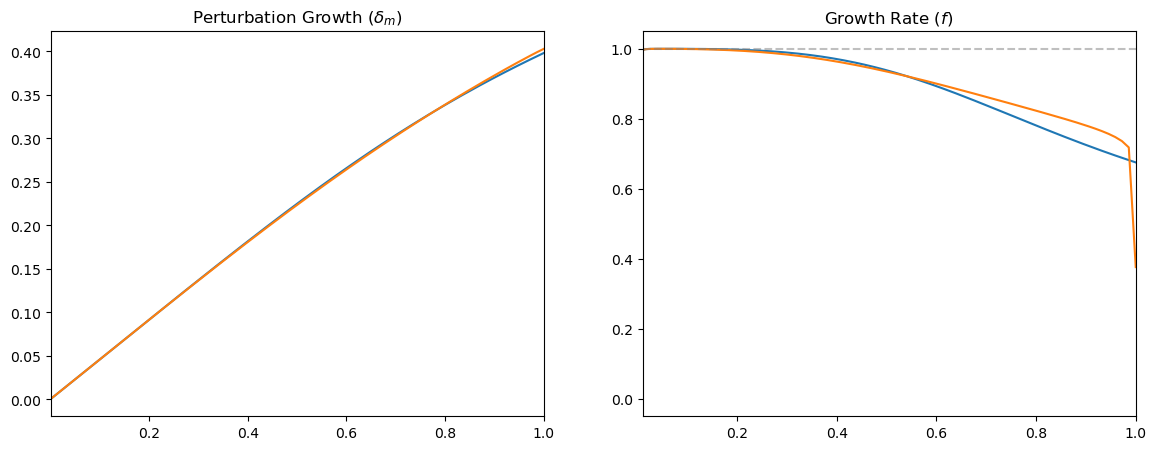

In [2]:
# Change Nend from 2 to 0 to focus on history up to today
z_LSS=1089
N_pert = np.linspace(-np.log(1 + z_LSS), 0, 500) 
a_pert = np.exp(N_pert)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, model in models.items():
    solver = CosmoSolver(model)
    solution = solver.solve(N_pert)
    
    delta = solution[:, 0]
    # Ensure we don't divide by zero and handle the array safely
    growth_rate = solution[:, 1] / np.where(delta == 0, 1e-10, delta)

    axes[0].plot(a_pert, delta, label=name)
    axes[1].plot(a_pert, growth_rate, label=name)

# Add a horizontal line at f=1 (Einstein-de Sitter limit)
axes[1].axhline(1, color='gray', linestyle='--', alpha=0.5, label='EdS (f=1)')

# Formatting
axes[0].set_title('Perturbation Growth ($\delta_m$)')
axes[1].set_title('Growth Rate ($f$)')
axes[0].set_xlim(1e-3, 1)
axes[1].set_xlim(1e-2, 1) # Zoom in to see the DE transition

<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:30: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_16370/2668534001.py:30: SyntaxWarning: invalid escape sequence '\d'
  axes[1,0].set_title("Density Contrast $\delta$")


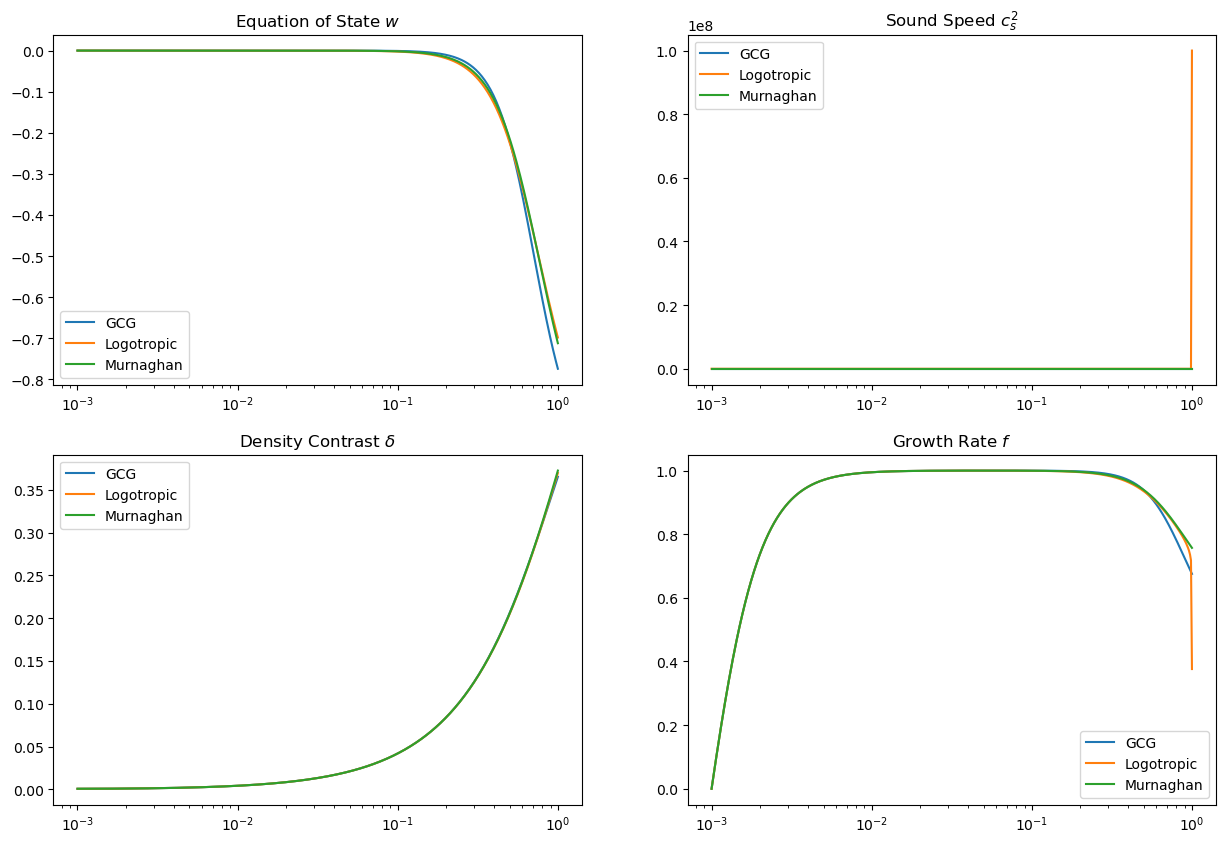

In [5]:
# In your notebook:
a_vals = np.logspace(-3, 0, 500)
models = {
    'GCG': GCGModel(alpha=0.2),
    'Logotropic': LogotropicModel(B=0.01),
    'Murnaghan': MurnaghanModel(alpha=0.03)
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for name, model in models.items():
    # Background
    w = [model.w_ude(ai) for ai in a_vals]
    cs2 = [model.cs2(ai) for ai in a_vals]
    
    # Perturbations
    solver = CosmoSolver(model)
    N_pert = np.log(a_vals)
    sol = solver.solve(N_pert)
    f = sol[:, 1] / (sol[:, 0] + 1e-10)

    axes[0,0].plot(a_vals, w, label=name)
    axes[0,1].plot(a_vals, cs2, label=name)
    axes[1,0].plot(a_vals, sol[:, 0], label=name) # delta
    axes[1,1].plot(a_vals, f, label=name) # growth rate

# Aesthetics
axes[0,0].set_title("Equation of State $w$")
axes[0,1].set_title("Sound Speed $c_s^2$")
axes[1,0].set_title("Density Contrast $\delta$")
axes[1,1].set_title("Growth Rate $f$")
for ax in axes.flat:
    ax.set_xscale('log')
    ax.legend()

plt.show()

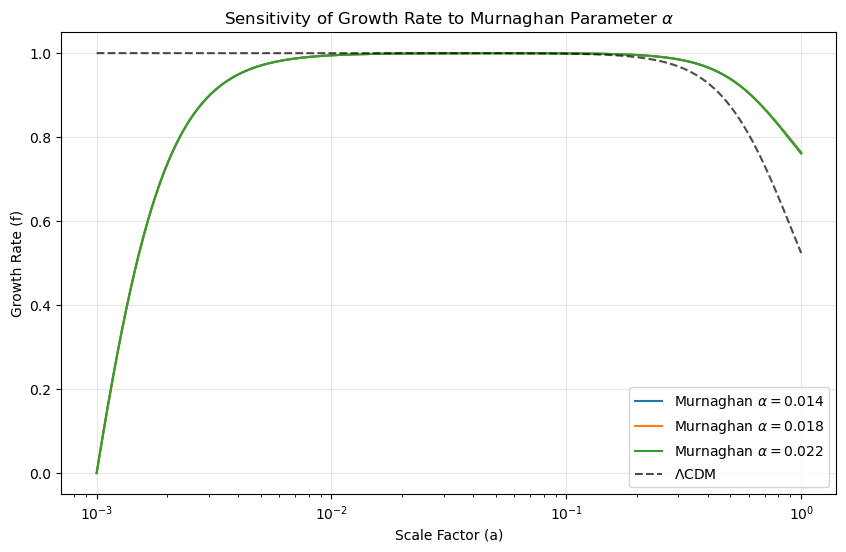

In [4]:
# Create a range for alpha as suggested by your text (0.014 to 0.022)
alphas = [0.014, 0.018, 0.022]
a_vals = np.logspace(-3, 0, 500)
N_pert = np.log(a_vals)

plt.figure(figsize=(10, 6))

for a_val in alphas:
    model = MurnaghanModel(alpha=a_val)
    solver = CosmoSolver(model)
    
    # Solve for perturbations
    solution = solver.solve(N_pert)
    delta = solution[:, 0]
    f = solution[:, 1] / (delta + 1e-10) # Growth Rate
    
    plt.plot(a_vals, f, label=rf'Murnaghan $\alpha={a_val}$')

# Add LambdaCDM for comparison (f approx Omega_m(a)^0.55)
f_lcdm = (0.3089 * a_vals**-3 / (0.3089 * a_vals**-3 + 0.6911))**0.55
plt.plot(a_vals, f_lcdm, 'k--', label=r'$\Lambda$CDM', alpha=0.7)

plt.xscale('log')
plt.xlabel('Scale Factor (a)')
plt.ylabel('Growth Rate (f)')
plt.title('Sensitivity of Growth Rate to Murnaghan Parameter ' + r'$\alpha$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
import pandas as pd

alphas = [0.014, 0.018, 0.022]
results = []

# Baseline LambdaCDM values
results.append({
    'Model': 'LambdaCDM',
    'alpha': '-',
    'q0': -0.55,  # Theoretical approx for Omega_m=0.3
    'j0': 1.00    # Constant for Lambda
})

for a_val in alphas:
    m = MurnaghanModel(alpha=a_val)
    q0, j0 = m.get_kinematics()
    results.append({
        'Model': 'Murnaghan',
        'alpha': a_val,
        'q0': round(q0, 4),
        'j0': round(j0, 4)
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))

    Model  alpha      q0     j0
LambdaCDM      - -0.5500 1.0000
Murnaghan  0.014 -0.5515 0.8439
Murnaghan  0.018 -0.5554 0.8597
Murnaghan  0.022 -0.5595 0.8761


In [7]:
# Load the results from your script
samples = np.load('murnaghan_samples.npy')

# Generate the plot instantly
labels = [r"$h_0$", r"$\Omega_m$", r"$\alpha$"]
fig = corner.corner(samples, labels=labels, show_titles=True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'murnaghan_samples.npy'

In [ ]:
# Get best-fit parameters (median of samples)
h0_bf, om_bf, alpha_bf = np.median(samples, axis=0)
model_bf = MurnaghanCosmology(h0_bf, om_bf, alpha_bf)

z_range = np.linspace(0, 2, 100)
H_theory = model_bf.H0 * model_bf.E(z_range)

plt.figure()
plt.errorbar(z_ohd, h_obs, yerr=h_err, fmt='o', label='OHD Data')
plt.plot(z_range, H_theory, 'r-', label='Murnaghan Best Fit')
plt.xlabel('Redshift z')
plt.ylabel('H(z)')
plt.legend()
plt.show()